In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgeocode
import xgboost as xgb
import shap

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

In [2]:
sold = pd.read_csv("C:/Users/44756/Documents/Postgrad/DSA8030/Data/sold_treated.csv", dtype = {'brokered_by':'string', 'street':'string', 'zip_code':'string'}, parse_dates = ['prev_sold_date'])

In [3]:
# Add lat/long columns based on zip code
nomi = pgeocode.Nominatim('us')
location_data = nomi.query_postal_code(sold['zip_code'].tolist())
sold['latzip'] = location_data['latitude'].values
sold['longzip'] = location_data['longitude'].values

In [4]:
# One hot encode state column
sold_dummy = pd.get_dummies(sold['state']).astype('int')
# enc = OneHotEncoder(sparse_output=False).astype('int')
# col = sold[['state']]
# enc_col = enc.fit_transform(col)
# state_df = pd.DataFrame(enc_col)
sold = pd.concat([sold, sold_dummy], axis = 1)

In [5]:
# Frequency encode city, street and broker
sold['cityfreq'] = sold['city'].map(sold['city'].value_counts())
sold['streetfreq'] = sold['street'].map(sold['street'].value_counts())
sold['brokerfreq'] = sold['brokered_by'].map(sold['brokered_by'].value_counts())

In [6]:
# Log transform target variable
sold['logprice'] = np.log(sold.price)

In [7]:
# Split train/val and test before modelling
sold_train, sold_test = train_test_split(sold, test_size = 0.2, random_state=1)

In [8]:
def build_model(model_type, cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'], rand_state=1):
    X = sold_train[cols]
    y = sold_train['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=rand_state)

    model = model_type
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    resids = y_val - y_val_pred
    percenterror = (y_val - y_val_pred) / y_val
    print('R^2', model.score(X_val, y_val))
    print('RMSE', root_mean_squared_error(y_val, y_val_pred))
    print('MAE', mean_absolute_error(y_val, y_val_pred))
    print('Positive residuals:', len(resids[resids > 0]))
    print('Negative residuals:', len(resids[resids < 0]))
    print('Average positive residual:', np.mean(resids[resids > 0]))
    print('Average negative residual:', np.mean(resids[resids < 0]))
    print('Average percentage error:', np.mean(abs(percenterror)))
    plt.scatter(y_val, y_val_pred, s = 0.01)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    return model, X, y_val_pred, resids, percenterror

In [9]:
def build_model_log(model_type, cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'], rand_state=1):
    X = sold_train[cols]
    y = sold_train['logprice']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=rand_state)

    model = model_type
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_val_pred_exp = np.exp(y_val_pred)
    y_val_exp = np.exp(y_val)
    resids = y_val_exp - y_val_pred_exp
    percenterror = (y_val_exp - y_val_pred_exp) / y_val_exp
    print('R^2', model.score(X_val, y_val))
    print('RMSE', root_mean_squared_error(y_val_exp, y_val_pred_exp))
    print('MAE', mean_absolute_error(y_val_exp, y_val_pred_exp))
    print('Positive residuals:', len(resids[resids > 0]))
    print('Negative residuals:', len(resids[resids < 0]))
    print('Average positive residual:', np.mean(resids[resids > 0]))
    print('Average negative residual:', np.mean(resids[resids < 0]))
    print('Average percentage error:', np.mean(abs(percenterror)))
    plt.scatter(y_val_exp, y_val_pred_exp, s = 0.01)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    return model, X, y_val_pred_exp, resids, percenterror

Linear Regression (main dataset variables only)

R^2 0.4594368454723302
RMSE 363049.3468927382
MAE 212114.25748569053
Positive residuals: 71480
Negative residuals: 89544
Average positive residual: 238290.45205349792
Average negative residual: -191218.67109568263
Average percentage error: 21.951571882114603


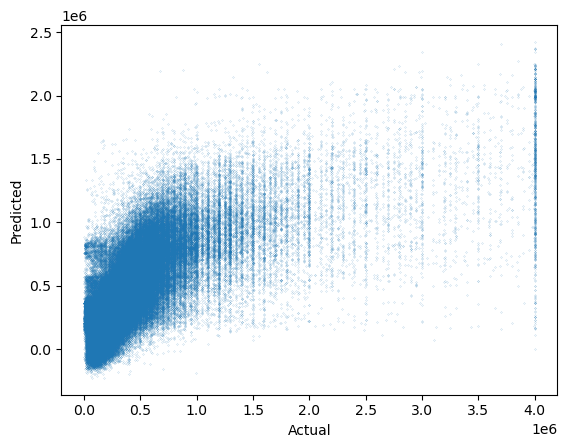

In [10]:
model_lr1, X_lr1, y_val_pred_lr1, resids_lr1, percenterror_lr1 = build_model(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [11]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model_lr1.feature_names_in_, 'coeff':model_lr1.coef_, 'abs_coeff':abs(model_lr1.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

,feature,coeff,abs_coeff
52,Utah,688827.955861,688827.955861
16,District of Columbia,501624.858395,501624.858395
29,Massachusetts,473801.522492,473801.522492
40,New York,366246.150791,366246.150791
51,Texas,-351644.071873,351644.071873
26,Louisiana,-326902.200670,326902.200670
39,New Mexico,-316102.678168,316102.678168
37,New Hampshire,302871.883854,302871.883854
32,Mississippi,-296670.936006,296670.936006
47,Rhode Island,286094.019161,286094.019161


Linear Regression Model (baseline + climate variables)

R^2 0.4944943487438648
RMSE 351079.48063936684
MAE 205990.10762577198
Positive residuals: 71924
Negative residuals: 89100
Average positive residual: 230338.4166504883
Average negative residual: -186335.4748727563
Average percentage error: 21.643657902974162


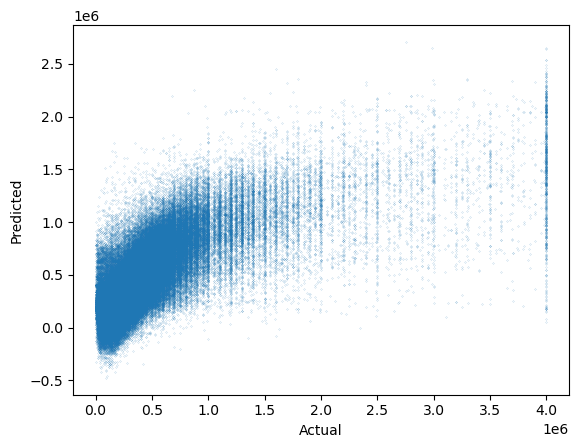

In [12]:
model_lr2, X_lr2, y_val_pred_lr2, resids_lr2, percenterror_lr2 = build_model(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [13]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model_lr2.feature_names_in_, 'coeff':model_lr2.coef_, 'abs_coeff':abs(model_lr2.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

,feature,coeff,abs_coeff
23,Hawaii,-794961.300366,794961.300366
56,Utah,553614.797995,553614.797995
20,District of Columbia,521516.707292,521516.707292
33,Massachusetts,477130.087384,477130.087384
30,Louisiana,-353976.171579,353976.171579
55,Texas,-347990.024334,347990.024334
62,Wyoming,-332980.015592,332980.015592
41,New Hampshire,321137.446183,321137.446183
44,New York,262832.612529,262832.612529
57,Vermont,258902.750562,258902.750562


Linear Regression Model (baseline + facilities/demographic variables)

R^2 0.6019764479739904
RMSE 311527.8122556024
MAE 184611.40803146255
Positive residuals: 76237
Negative residuals: 84787
Average positive residual: 194735.97545589565
Average negative residual: -175507.8114100878
Average percentage error: 22.79431728747073


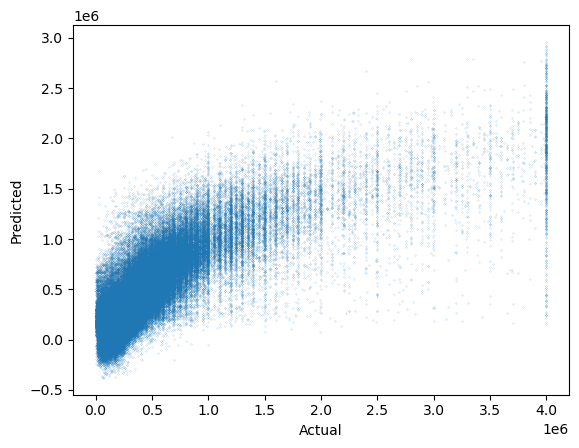

In [14]:
model_lr3, X_lr3, y_val_pred_lr3, resids_lr3, percenterror_lr3 = build_model(LinearRegression(),['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model_lr3.feature_names_in_, 'coeff':model_lr3.coef_, 'abs_coeff':abs(model_lr3.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

,feature,coeff,abs_coeff
63,Utah,460923.003443,460923.003443
40,Massachusetts,427254.604411,427254.604411
48,New Hampshire,340025.209984,340025.209984
62,Texas,-318670.536857,318670.536857
64,Vermont,301096.988501,301096.988501
21,Arizona,-276653.471085,276653.471085
51,New York,274220.720977,274220.720977
58,Rhode Island,273964.399499,273964.399499
69,Wyoming,-261673.709049,261673.709049
25,Connecticut,253527.975983,253527.975983


Linear Regression Model (all variables)

R^2 0.6066273720311042
RMSE 309702.355327632
MAE 182449.0914626042
Positive residuals: 76482
Negative residuals: 84542
Average positive residual: 192039.44173370473
Average negative residual: -173773.05860988822
Average percentage error: 22.18745574418501


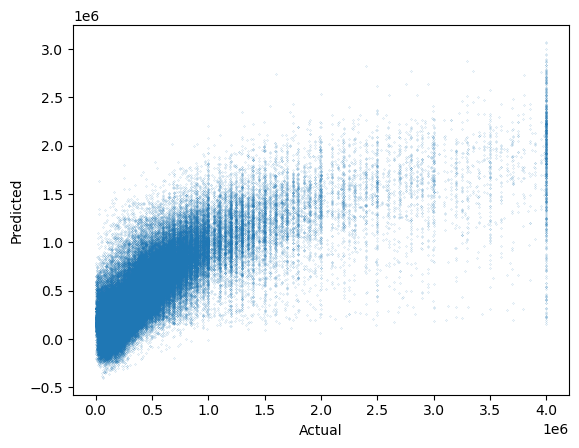

In [ ]:
model_lr4, X_lr4, y_val_pred_lr4, resids_lr4, percenterror_lr4 = build_model(LinearRegression())

In [17]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model_lr4.feature_names_in_, 'coeff':model_lr4.coef_, 'abs_coeff':abs(model_lr4.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

,feature,coeff,abs_coeff
44,Massachusetts,403850.902043,403850.902043
34,Hawaii,-356880.864981,356880.864981
73,Wyoming,-346117.384874,346117.384874
67,Utah,342029.172136,342029.172136
52,New Hampshire,301386.228456,301386.228456
66,Texas,-293625.231608,293625.231608
31,District of Columbia,256926.634107,256926.634107
62,Rhode Island,239857.383766,239857.383766
68,Vermont,232021.038293,232021.038293
29,Connecticut,231672.938433,231672.938433


XGBoost (all variables, all vars Vermont, Indiana, North Dakota, New Mexico, New Hampshire, Minnesota, Maine, Delaware, Alabama, Wyoming)

R^2 0.8291569183389692
RMSE 204099.12271183284
MAE 104614.58455939015
Positive residuals: 74547
Negative residuals: 86477
Average positive residual: 113273.04198685489
Average negative residual: -97150.61118097491
Average percentage error: 24.886877533340595


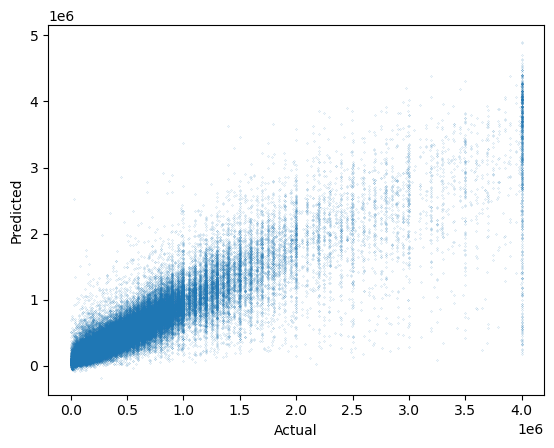

In [ ]:
model_xgb1, X_xgb1, y_val_pred_xgb1, resids_xgb1, percenterror_xgb1 = build_model(xgb.XGBRegressor(eval_metric=['mae', 'rmse']), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns','Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin'])

In [19]:
params = [{'max_depth': [3,4,5,6,7,8,9],
         'learning_rate': [0.2,0.3,0.4],
         'min_child_weight': [0,1,2,3]}]

gs_xgb = GridSearchCV(xgb.XGBRegressor(eval_metric=['mae', 'rmse']),
                      param_grid=params,
                      scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                      refit='r2',
                      cv=5)

X = sold_train[['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']]
y = sold_train['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

gs_xgb.fit(X_train, y_train)
gs_xgb.best_params_

{'learning_rate': 0.2, 'max_depth': 9, 'min_child_weight': 3}

Best hyperparameters of the above three seem to be 0.2, 10/11 (different metrics prefer either), 3

R^2 0.8473303592562226
RMSE 192938.448333626
MAE 94340.29387183287
Positive residuals: 74722
Negative residuals: 86302
Average positive residual: 101767.00031754156
Average negative residual: -87910.10269391988
Average percentage error: 28.833662101463396


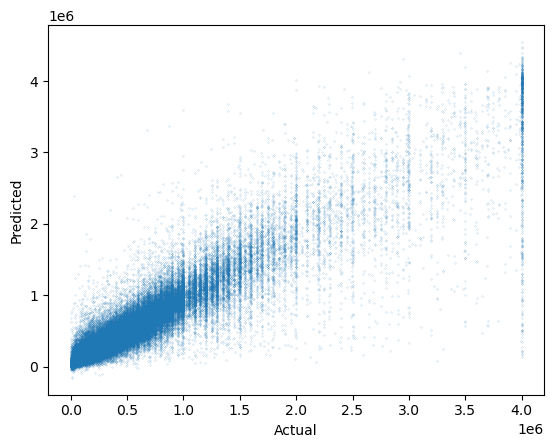

In [ ]:
model_xgb2, X_xgb2, y_val_pred_xgb2, resids_xgb2, percenterror_xgb2 = build_model(xgb.XGBRegressor(eval_metric=['mae', 'rmse'], learning_rate = 0.2, max_depth = 10, min_child_weight = 3), cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns','Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts', 'Michigan', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Jersey', 'New York', 'North Carolina', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin'])

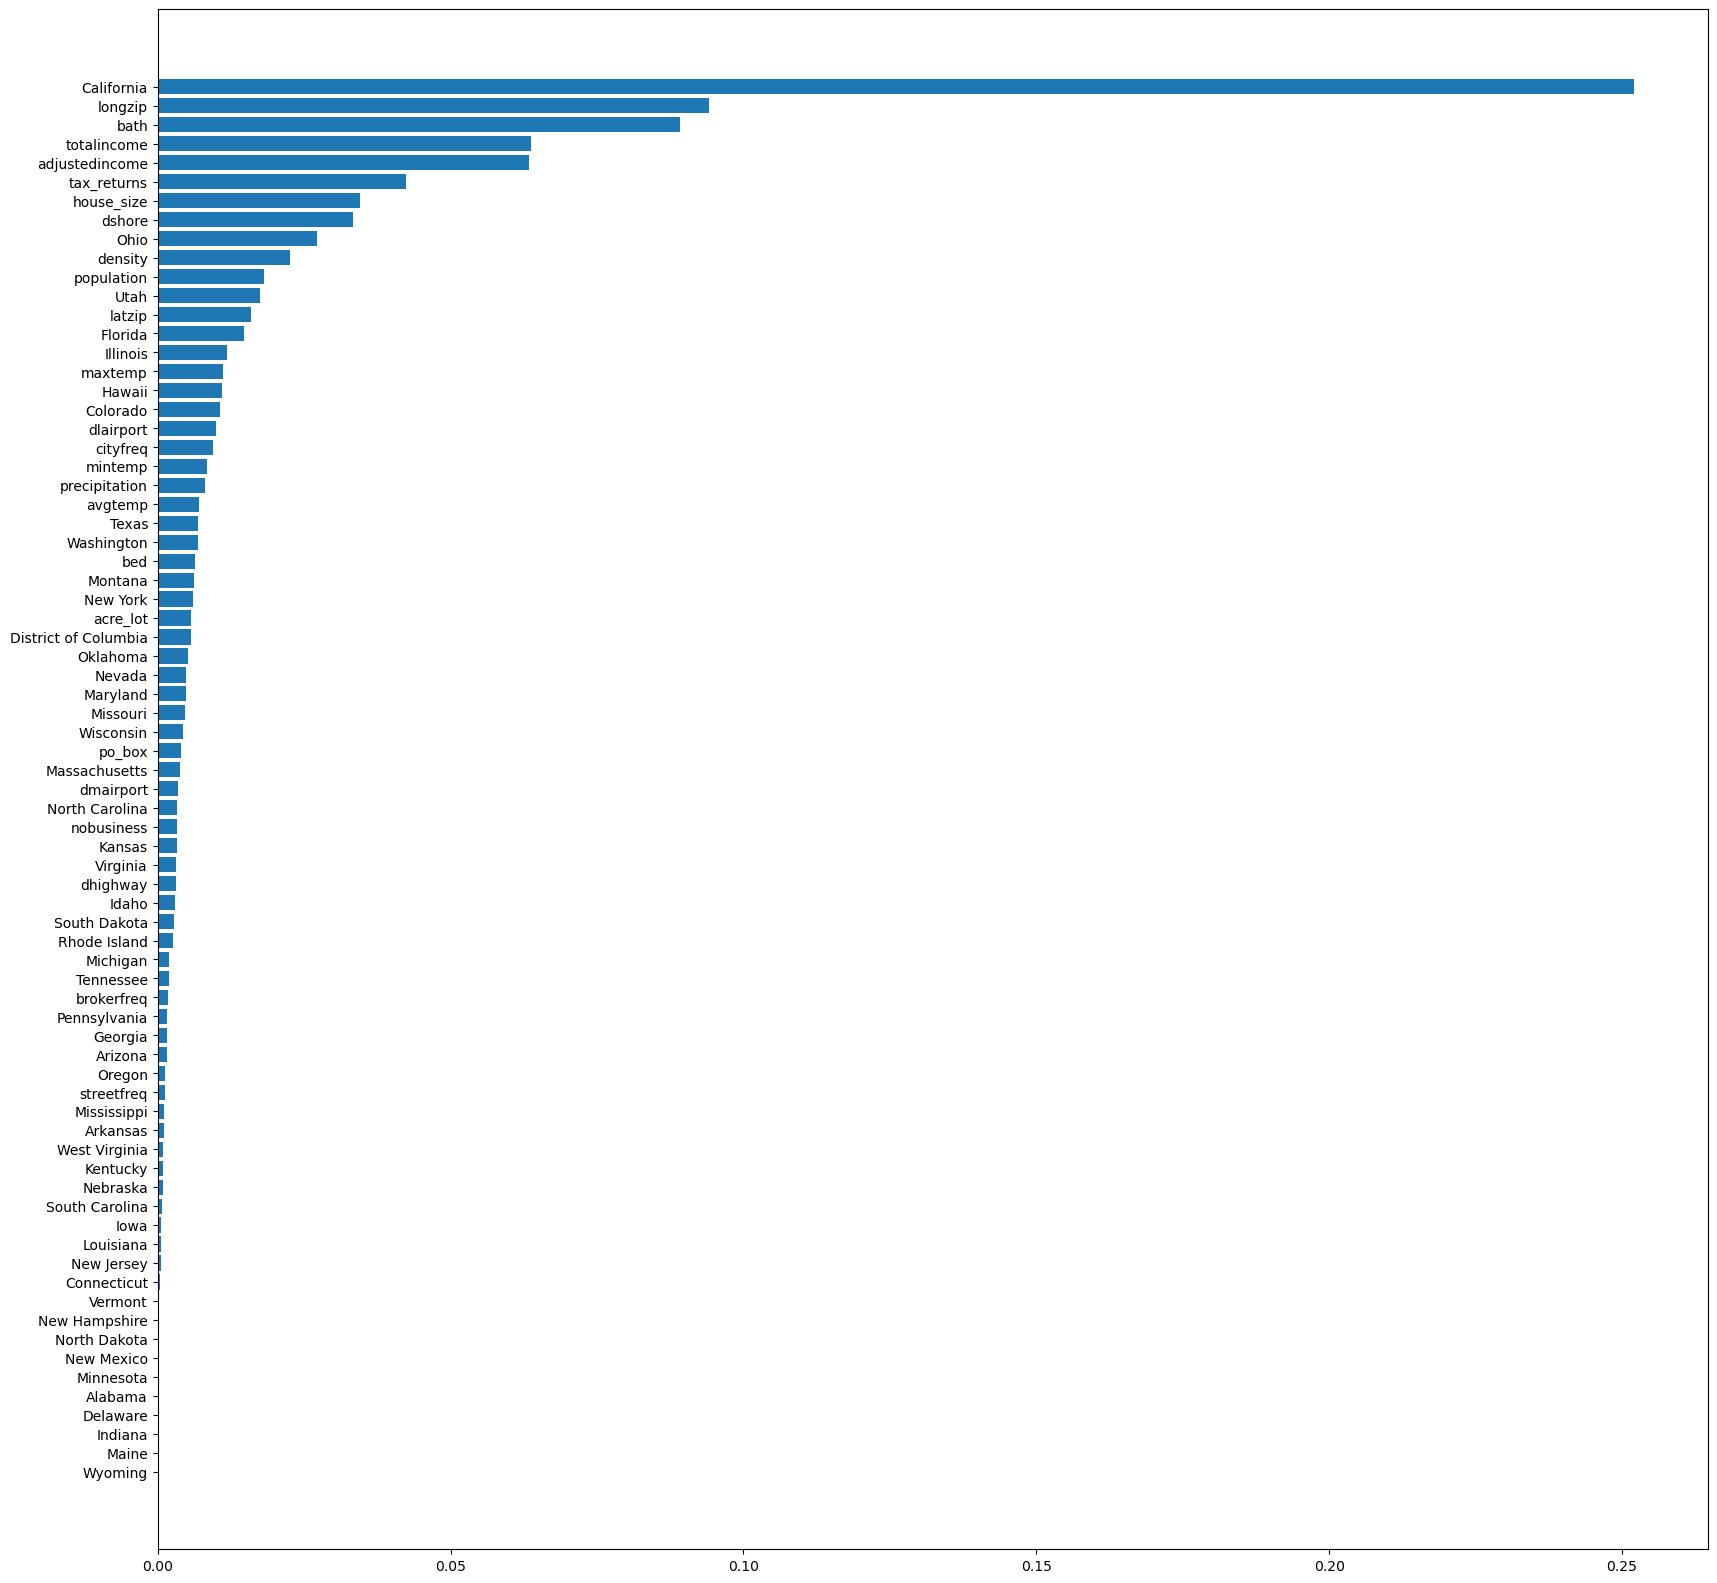

In [19]:
sorted_idx = model_xgb1.feature_importances_.argsort()
plt.figure(figsize=(20,20))
plt.barh(X_xgb1.columns[sorted_idx], model_xgb1.feature_importances_[sorted_idx])
plt.show()

In [66]:
pd.DataFrame([X_xgb1.columns, model_xgb1.feature_importances_]).T.sort_values(by = 1, ascending = False)

,0,1
27,California,0.252024
5,longzip,0.094091
1,bath,0.089192
21,totalincome,0.06377
22,adjustedincome,0.063312
23,tax_returns,0.04243
3,house_size,0.034463
19,dshore,0.03334
58,Ohio,0.027272
15,density,0.022612


In [20]:
explainer_xgb1 = shap.Explainer(model_xgb1)
X_train, X_val, y_train, y_val = train_test_split(X_xgb1, sold_train['price'], test_size=0.25, random_state=1)
shap_values_xgb1 = explainer_xgb1.shap_values(X_val)

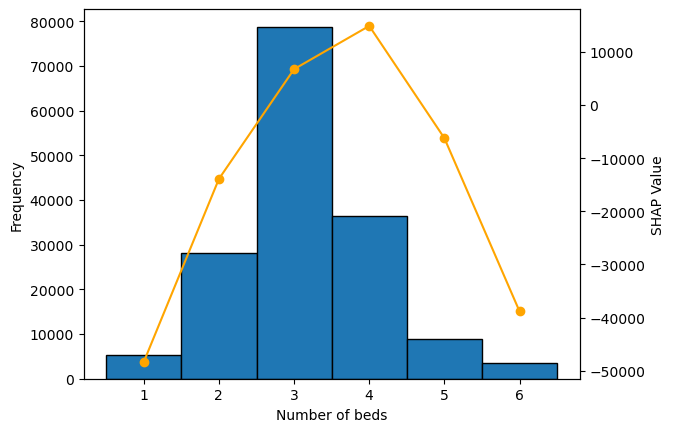

In [21]:
# Bed univariate
fig, ax = plt.subplots()

hist = ax.hist(X_val.bed, ec = 'black', bins = np.arange(0.5,7.5))
shaps = [np.median(shap_values_xgb1[X_val.bed == x, 0]) for x in np.arange(1,7)]
ax.set_xticks(ticks = np.arange(0,7), labels = np.arange(0,7))
ax.set_xlabel('Number of beds')
ax.set_ylabel('Frequency')
ax2 = ax.twinx()
ax2.plot(np.arange(1,7), shaps, color = 'orange')
ax2.scatter(np.arange(1,7), shaps, color = 'orange')
ax2.set_ylabel('SHAP Value')
plt.show()

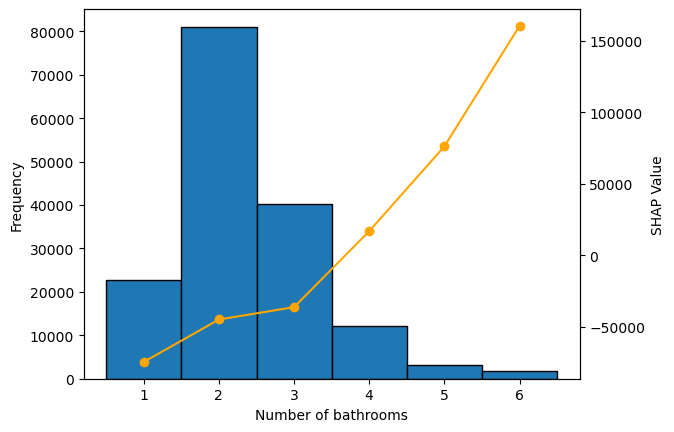

In [22]:
# Bath univariate
fig, ax = plt.subplots()

hist = ax.hist(X_val.bath, ec = 'black', bins = np.arange(0.5,7.5))
shaps = [np.median(shap_values_xgb1[X_val.bed == x, 1]) for x in np.arange(1,7)]
ax.set_xticks(ticks = np.arange(0,7), labels = np.arange(0,7))
ax.set_xlabel('Number of bathrooms')
ax.set_ylabel('Frequency')
ax2 = ax.twinx()
ax2.plot(np.arange(1,7), shaps, color = 'orange')
ax2.scatter(np.arange(1,7), shaps, color = 'orange')
ax2.set_ylabel('SHAP Value')
plt.show()

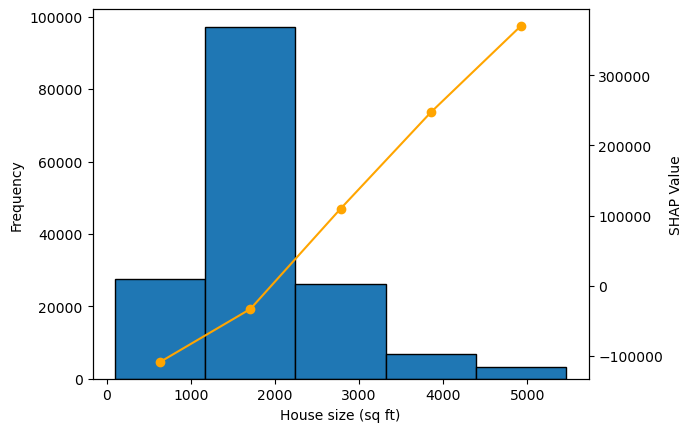

In [59]:
# House size univariate
fig, ax = plt.subplots()

hist = ax.hist(X_val.house_size, ec = 'black', bins = 5)
midpts = [((hist[1][x] + hist[1][x+1])/2) for x in range(len(hist[1])-1)]
shaps = [np.median(shap_values_xgb1[(X_val.house_size >= hist[1][x]) & (X_val.house_size < hist[1][x+1]), 3]) for x in range(len(hist[1])-1)]
ax.set_xlabel('House size (sq ft)')
ax.set_ylabel('Frequency')
ax2 = ax.twinx()
ax2.plot(midpts, shaps, color = 'orange')
ax2.scatter(midpts, shaps, color = 'orange')
ax2.set_ylabel('SHAP Value')
plt.show()

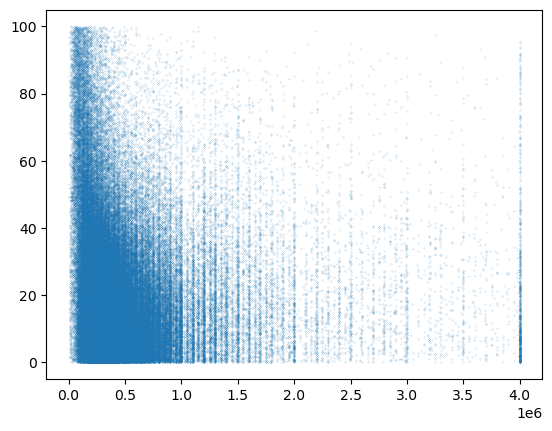

In [56]:
fig, ax = plt.subplots()

ax.scatter(y_val[abs(percenterror_xgb1) < 1], abs(percenterror_xgb1*100)[abs(percenterror_xgb1) < 1], s = 0.01)

Decision Tree Regressor (all variables, default parameters)

R^2 0.6861776352047394
RMSE 276620.51466429344
MAE 126901.2251043832
Positive residuals: 77760
Negative residuals: 79541
Average positive residual: 127661.24687743837
Average negative residual: -132097.96600518716
Average percentage error: 47.48606744989504


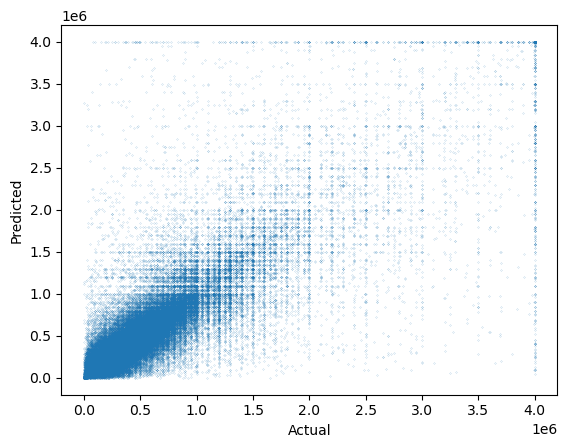

In [24]:
model_dt1, X_dt1, y_val_pred_dt1, resids_dt1, percenterror_dt1 = build_model(DecisionTreeRegressor())

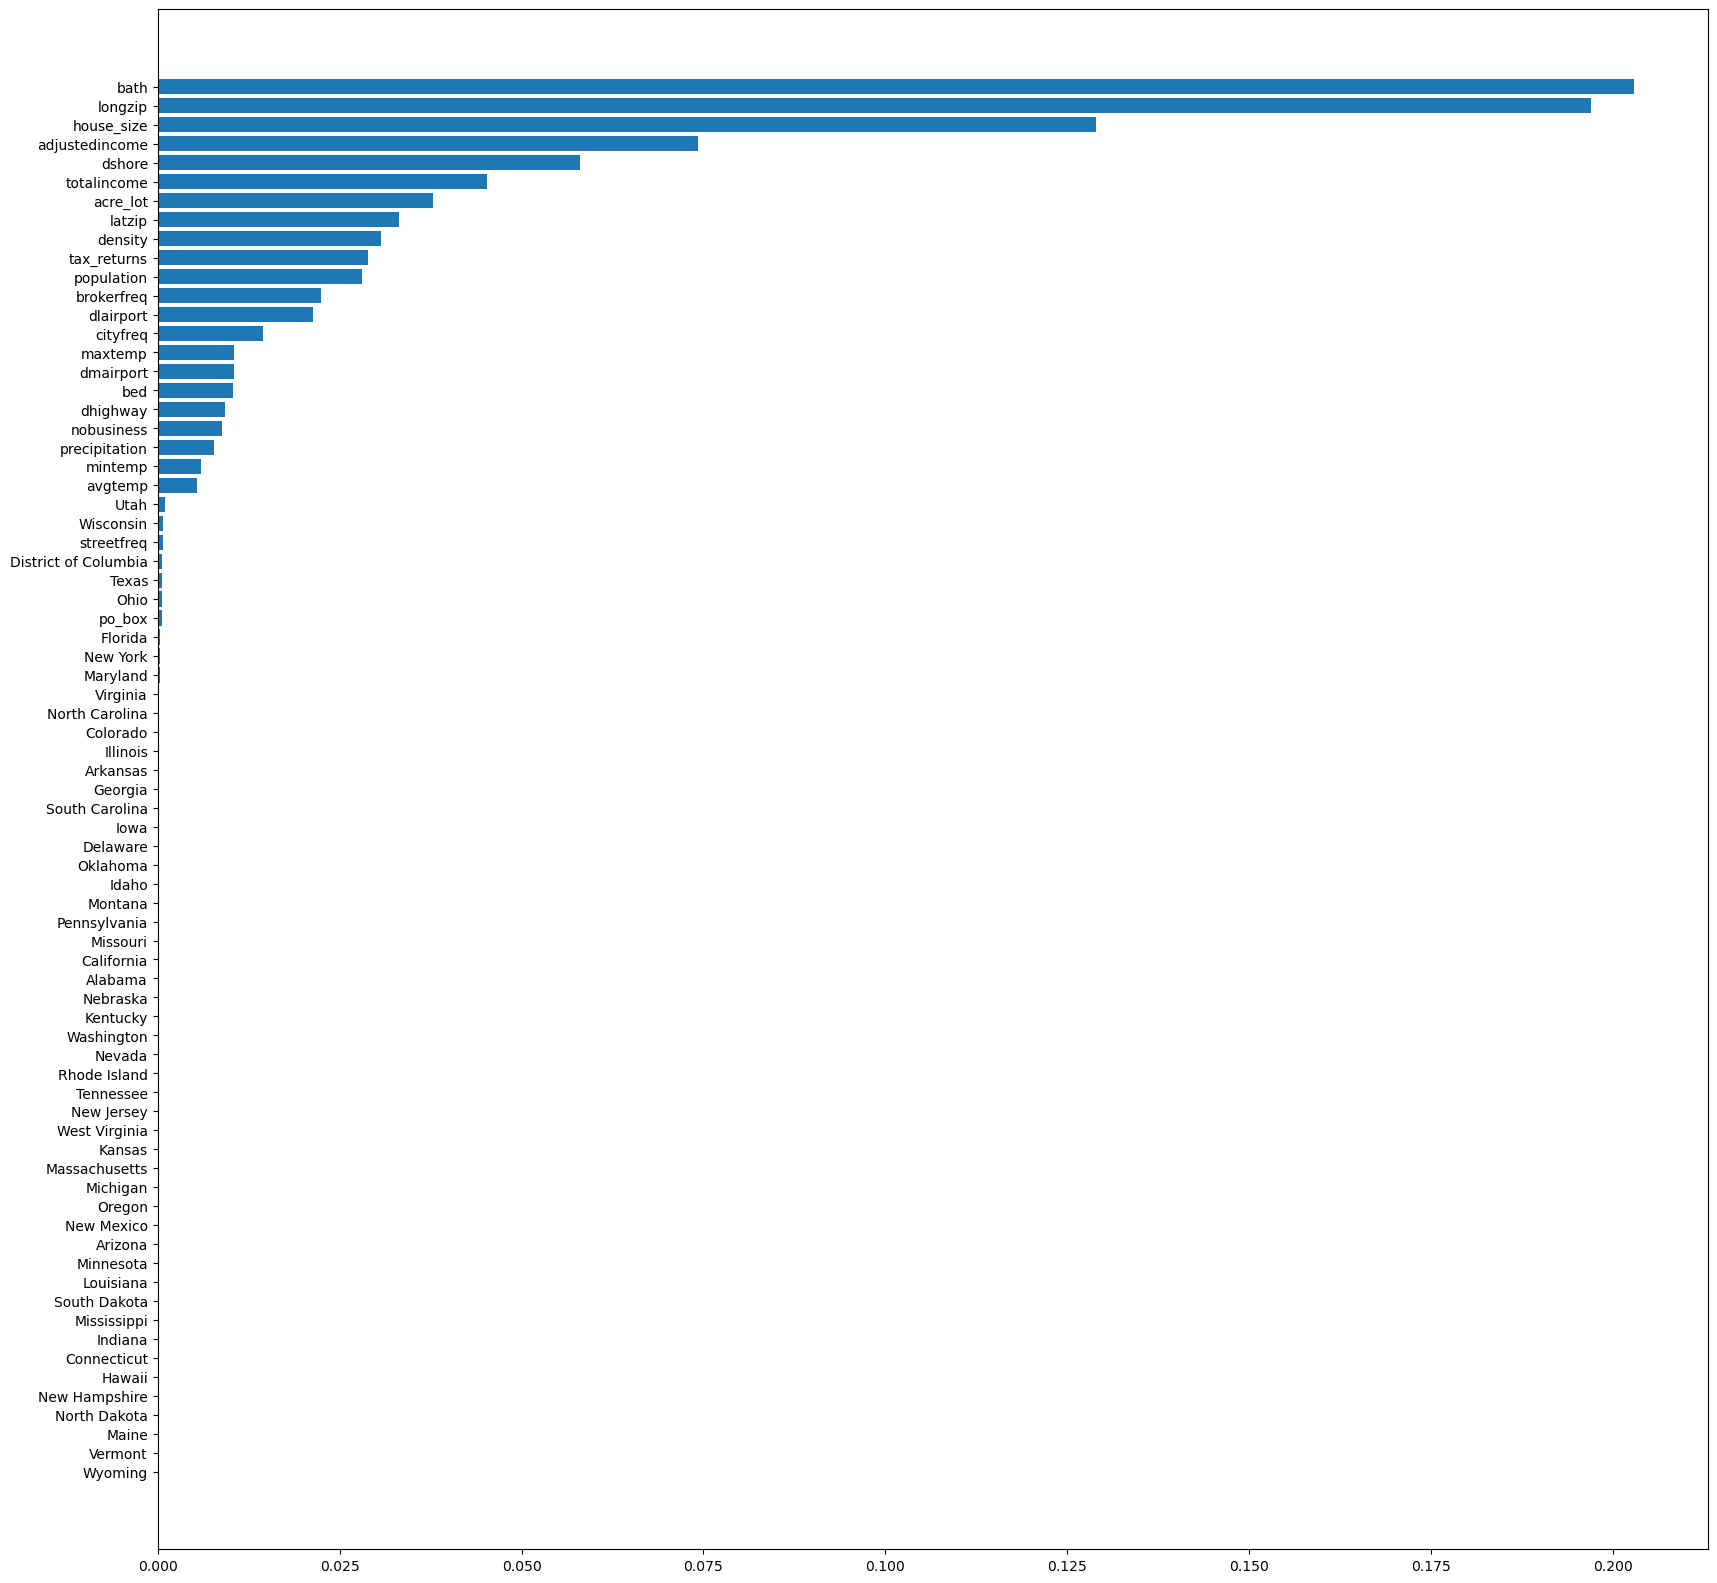

In [25]:
sorted_idx = model_dt1.tree_.compute_feature_importances().argsort()
plt.figure(figsize=(20,20))
plt.barh(X_dt1.columns[sorted_idx], model_dt1.feature_importances_[sorted_idx])
plt.show()

Random Forest Regressor (all variables, default hyperparameters)

R^2 0.836109960087424
RMSE 199902.7277001317
MAE 93345.71383973154
Positive residuals: 72579
Negative residuals: 88380
Average positive residual: 99998.55700629053
Average negative residual: -87950.94994760546
Average percentage error: 38.858794034955466


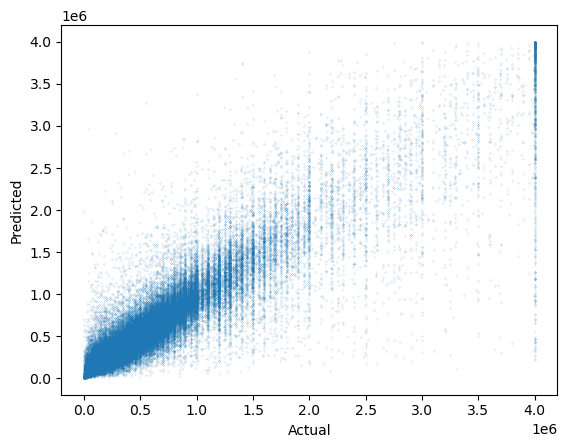

In [26]:
model_rf1, X_rf1, y_val_pred_rf1, resids_rf1, percenterror_rf1 = build_model(RandomForestRegressor())

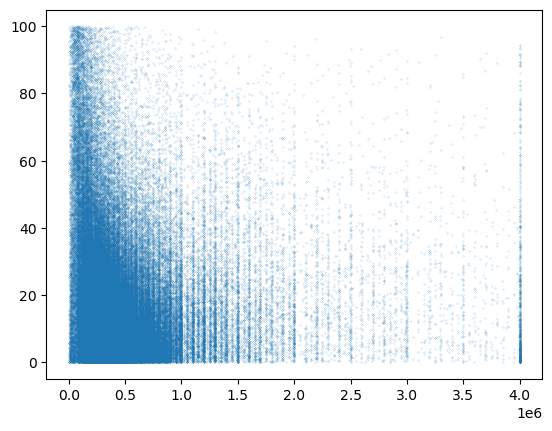

In [57]:
fig, ax = plt.subplots()

ax.scatter(y_val[abs(percenterror_rf1) < 1], abs(percenterror_rf1*100)[abs(percenterror_rf1) < 1], s = 0.01)

In [ ]:
explainer_rf1 = shap.Explainer(model_rf1)
X_train, X_val, y_train, y_val = train_test_split(X_rf1, sold_train['price'], test_size=0.25, random_state=1)
shap_values_rf1 = explainer_rf1.shap_values(X_val)

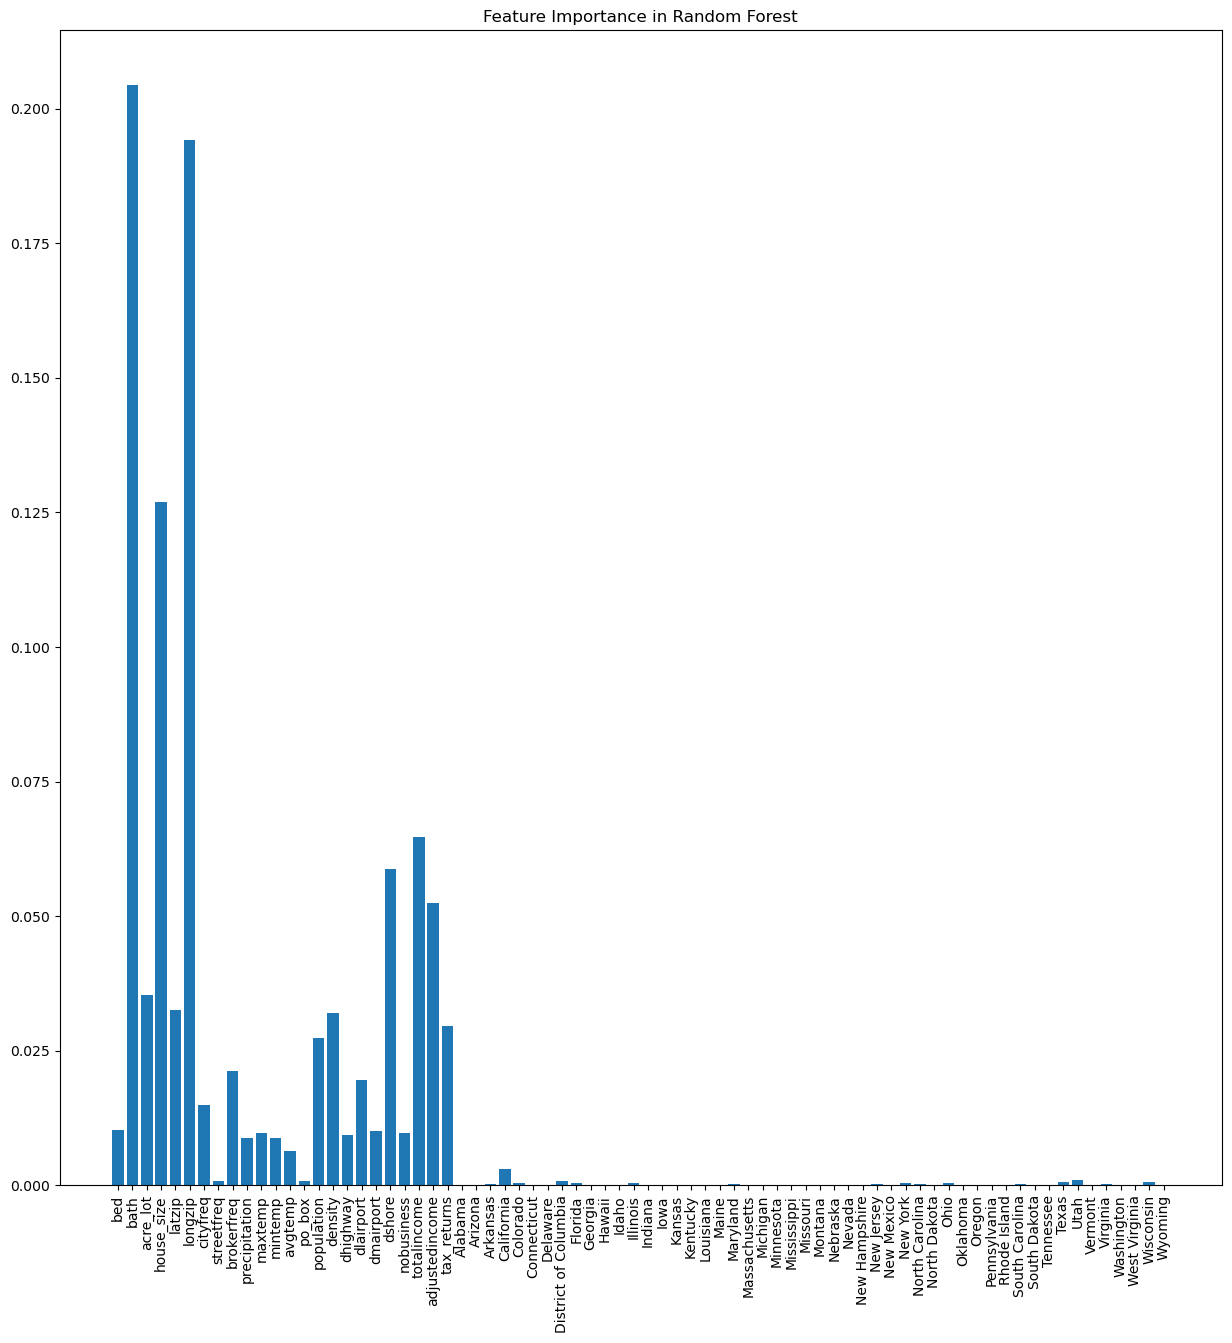

In [60]:
importance = model_rf1.feature_importances_
plt.subplots(figsize=(15,15))
plt.bar(range(X_rf1.shape[1]), importance)
plt.xticks(range(X_rf1.shape[1]), X_rf1.columns, rotation=90)
plt.title("Feature Importance in Random Forest")
plt.show()

In [ ]:
params = [{'criterion': ['squared_error'],
           'n_estimators': [50,100,150],
         'max_depth': [None,10,11,12],
         'min_samples_split': [1,2,3,4],
         'min_samples_leaf': [1,2,3,4]}]

gs_rf = GridSearchCV(RandomForestRegressor(),
                      param_grid=params,
                      scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
                      refit='r2',
                      cv=5,
                      verbose=3)

sample_sold = sold_train.sample(frac = 0.25)
X = sample_sold[['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']]
y = sample_sold['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

gs_rf.fit(X_train, y_train)
gs_rf.best_params_

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
[CV 1/5] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=50; neg_mean_absolute_error: (test=nan) neg_root_mean_squared_error: (test=nan) r2: (test=nan) total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=50; neg_mean_absolute_error: (test=nan) neg_root_mean_squared_error: (test=nan) r2: (test=nan) total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=50; neg_mean_absolute_error: (test=nan) neg_root_mean_squared_error: (test=nan) r2: (test=nan) total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=None, min_samples_leaf=1, min_samples_split=1, n_estimators=50; neg_mean_absolute_error: (test=nan) neg_root_mean_squared_error: (test=nan) r2: (test=nan) total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=

KeyboardInterrupt: 

SVM (all variables, default hyperparameters)

c:\Users\44756\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


R^2 0.3360241920093787
RMSE 402363.49117137486
MAE 242587.5562279942


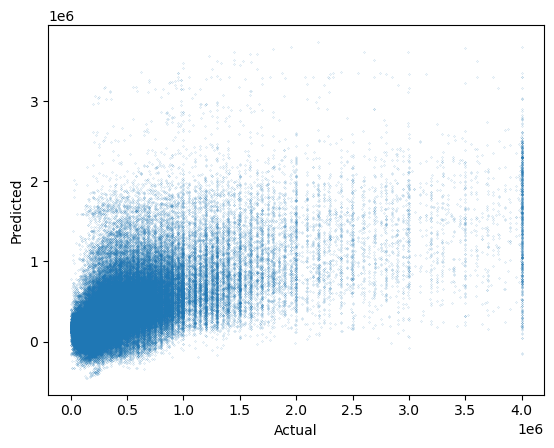

In [ ]:
model_svm1, X_svm1, y_val_pred_svm1, resids_svm1, percenterror_svm1 = build_model(LinearSVR())

Linear Regression (main variables only, log price)

R^2 0.4501950982591425
RMSE 360905.48570894153
MAE 185929.28176297998
Positive residuals: 91856
Negative residuals: 69168
Average positive residual: 221442.49610742557
Average negative residual: -138767.27307654414
Average percentage error: 18.286403823898663


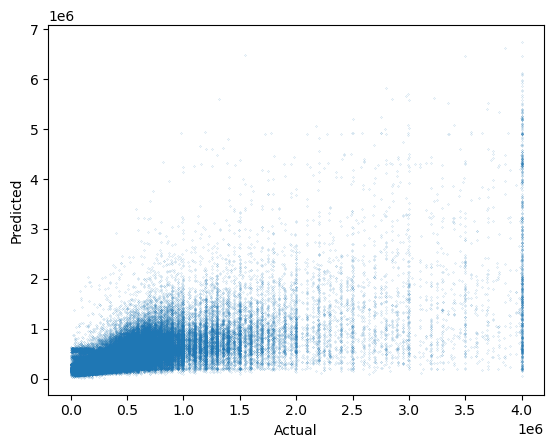

In [28]:
model_lr1_log, X_lr1_log, y_val_pred_lr1_log, resids_lr1_log, percenterror_lr1_log = build_model_log(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (main + climate variables only, log price)

R^2 0.47583796821602264
RMSE 350509.32700821484
MAE 177925.8625110473
Positive residuals: 92586
Negative residuals: 68438
Average positive residual: 207652.43367348926
Average negative residual: -137710.42200071897
Average percentage error: 18.441661814769706


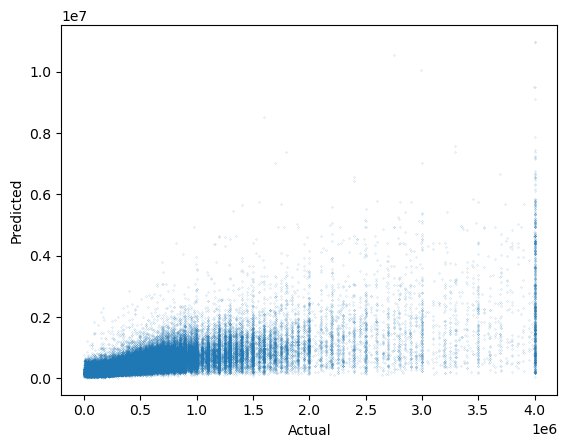

In [29]:
model_lr2_log, X_lr2_log, y_val_pred_lr2_log, resids_lr2_log, percenterror_lr2_log = build_model_log(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (main + facilities/demo variables, log price)

R^2 0.5532137318722673
RMSE 340271.19311821746
MAE 161224.38773978184
Positive residuals: 93835
Negative residuals: 67189
Average positive residual: 172768.64324584138
Average negative residual: -145101.8793617573
Average percentage error: 16.177883776516257


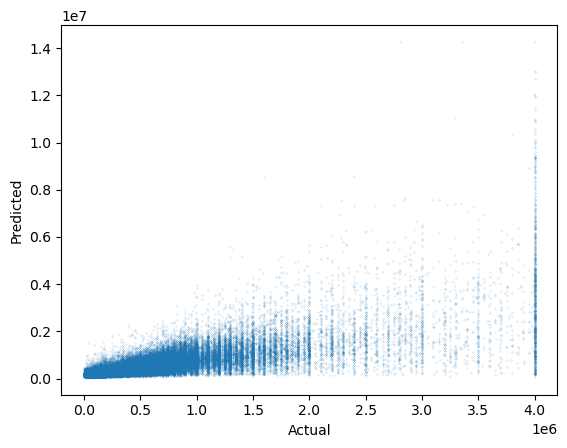

In [30]:
model_lr3_log, X_lr3_log, y_val_pred_lr3_log, resids_lr3_log, percenterror_lr3_log = build_model_log(LinearRegression(),['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (all vars, log price)

R^2 0.5552311866620578
RMSE 343552.568302323
MAE 160968.68563215638
Positive residuals: 94140
Negative residuals: 66884
Average positive residual: 171122.05524142258
Average negative residual: -146677.7010167578
Average percentage error: 16.270038730636053


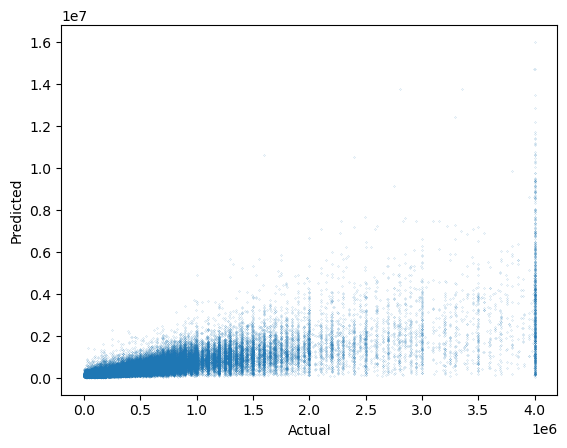

In [31]:
model_lr4_log, X_lr4_log, y_val_pred_lr4_log, resids_lr4_log, percenterror_lr4_log = build_model_log(LinearRegression())

XGBoost (all vars, default hyper, log price)

R^2 0.7950090519640406
RMSE 218115.32375232005
MAE 103633.82595172903
Positive residuals: 84711
Negative residuals: 76313
Average positive residual: 120249.45813154944
Average negative residual: -85189.69693590255
Average percentage error: 16.1595902635365


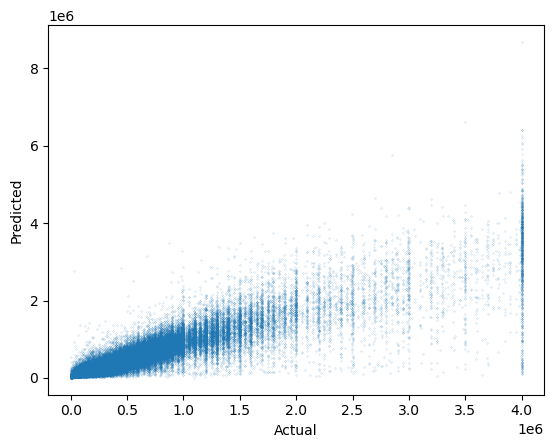

In [32]:
model_lr4_log, X_lr4_log, y_val_pred_lr4_log, resids_lr4_log, percenterror_lr4_log = build_model_log(xgb.XGBRegressor(eval_metric=['mae', 'rmse']))

Decision Tree Regressor (all vars, default hyper, log price)

R^2 0.6548311706871328
RMSE 274539.3252382711
MAE 126452.31858386722
Positive residuals: 78739
Negative residuals: 78785
Average positive residual: 128291.27135238599
Average negative residual: -130232.04585432645
Average percentage error: 31.9042833349289


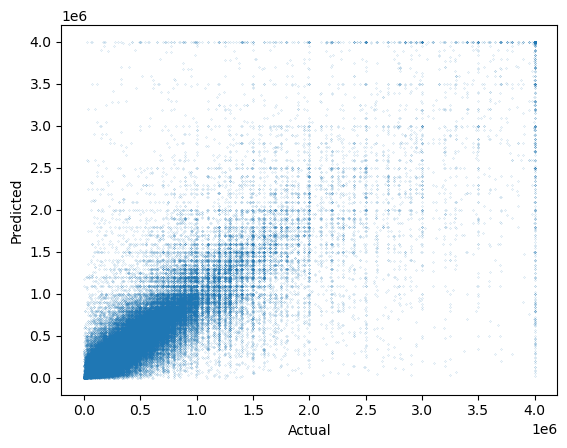

In [33]:
model_dt1_log, X_dt1_log, y_val_pred_dt1_log, resids_dt1_log, percenterror_dt1_log = build_model_log(DecisionTreeRegressor())

Random Forest Regressor (all vars, default hyper, log price)

R^2 0.8203888819897406
RMSE 201108.57708228016
MAE 90169.45480852874
Positive residuals: 85093
Negative residuals: 75929
Average positive residual: 107019.85577475031
Average negative residual: -71287.72542306241
Average percentage error: 18.651841257886545


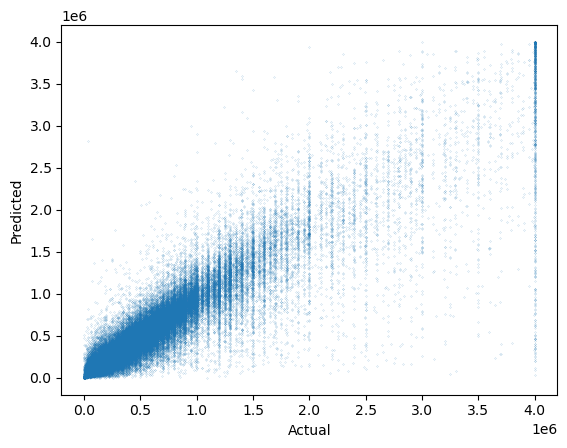

In [34]:
model_rf1_log, X_rf1_log, y_val_pred_rf1_log, resids_rf1_log, percenterror_rf1_log = build_model_log(RandomForestRegressor())

SVG (all variables, default hyper, log price)

c:\Users\44756\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


R^2 -12.009300425404959
RMSE 7165799046160.989
MAE 214290606160.12494


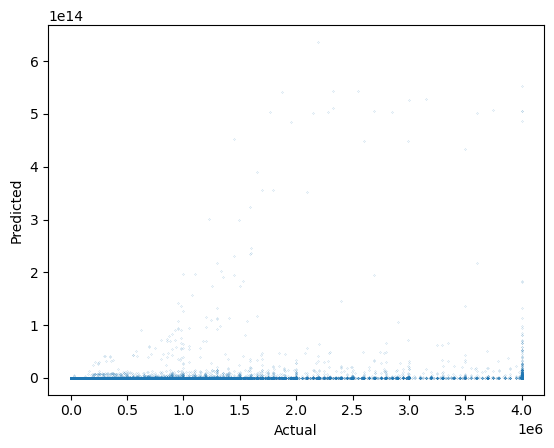

In [ ]:
model_svm1_log, X_svm1_log, y_val_pred_svm1_log, resids_svm1_log, percenterror_svm1_log = build_model_log(LinearSVR())